In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

In [4]:
def psnrFun(m1, m2):
    diff = (m1 - m2).reshape(-1)
    mse = np.dot(np.transpose(diff), diff) / diff.shape[0]
    psnr = 10*np.log10(1/mse)
    return psnr

Define a function that implements the OMP

In [5]:
def OMP(s, D, L, tau):
  N = D.shape[1]
  x = np.zeros(N)
  r = s
  omega = []
  while np.count_nonzero(x) < L and np.linalg.norm(r) > tau:
      e = np.zeros(N)
      for j in range(N):
          e[j] = np.linalg.norm(r)**2 - ((r.T @ D[:, j])  / np.linalg.norm(D[:, j]))**2
      jStar = np.argmin(e)
      omega = np.append(omega, jStar).astype(int)
      x_omega =  np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s
      x = np.zeros(N)
      x[omega] = x_omega 
      r = s - D @ x
  return x

Load the image and rescale it in $[0,1]$

In [6]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [7]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [8]:
psnr_noisy = psnrFun(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

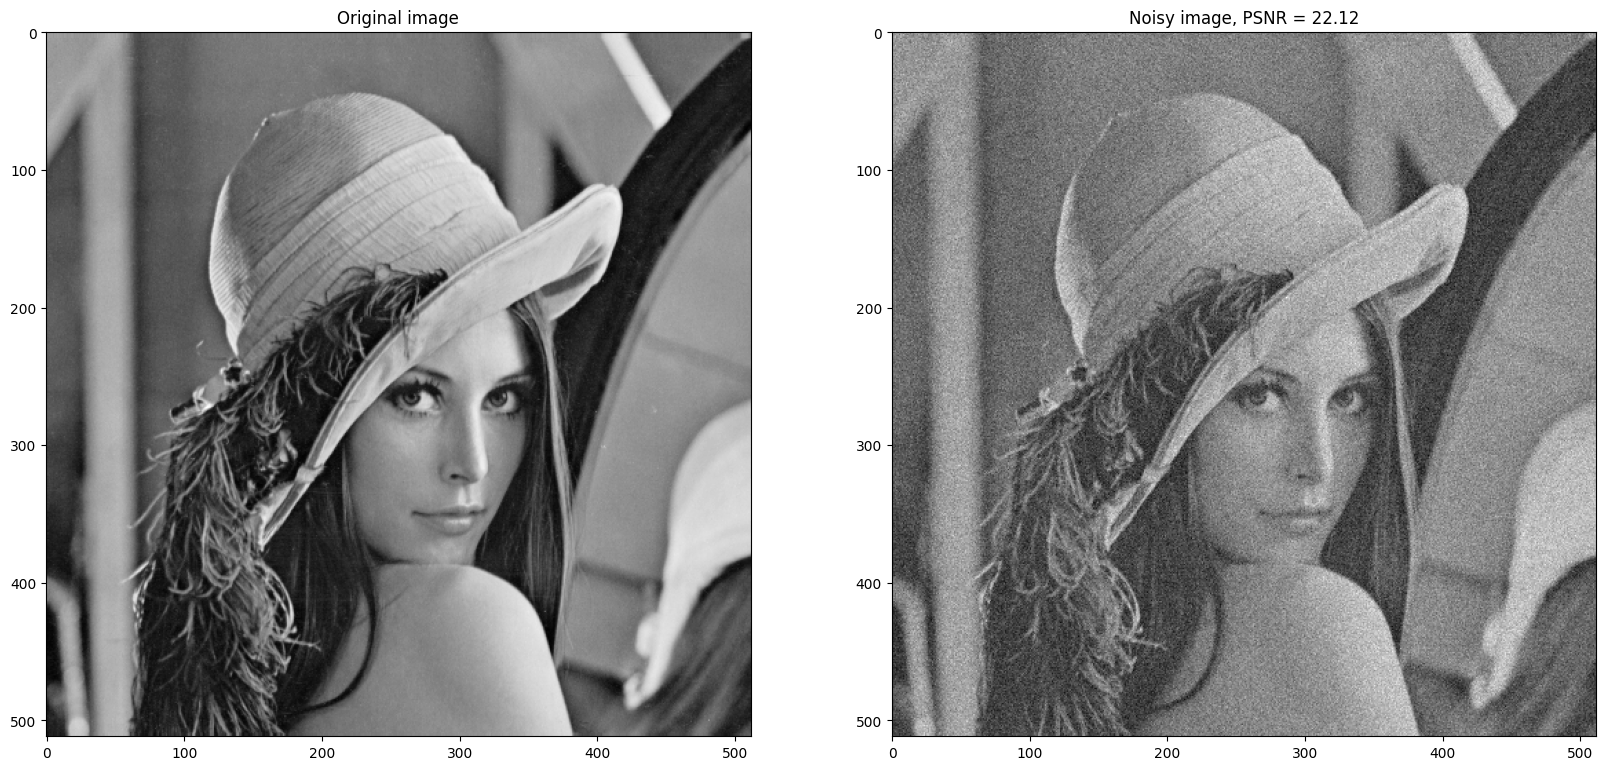

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Load and display the dictionary learned from patches

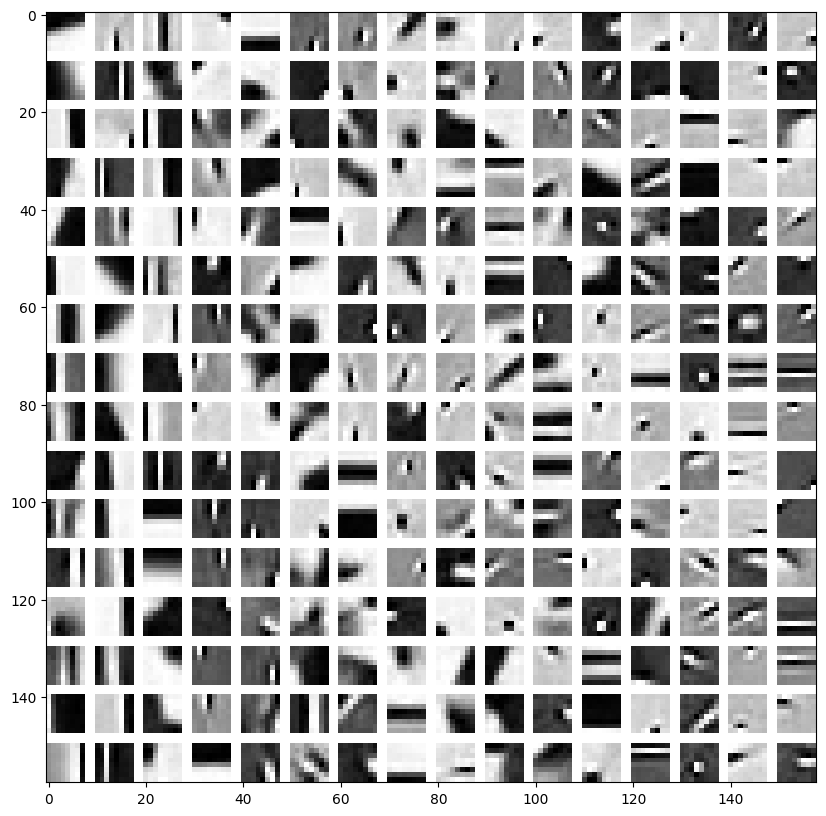

In [10]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Denoising
---------


In [11]:
# initialize the estimated image
img_hat = np.zeros(imsz)

# initialize the weight matrix
weights = np.zeros(imsz)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 1 # STEP = 1 might be very time consuming, start with larger STEP

L = M

Operate patchwise

In [12]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape(-1)

        # store and subtract the mean
        s_mean = np.mean(s)
        sTilde = s - s_mean  

        # perform the sparse coding
        x = OMP(sTilde, D, L, tau)

        # perform the reconstruction
        s_hat = np.matmul(D, x)


        # add back the mean
        s_hat = (s_hat + s_mean).reshape((8,8))

        w = 1
        # put the denoised patch into the estimated image using uniform weights
#        UPDATE img_hat
        img_hat[i:i+p, j:j+p] = img_hat[i:i+p, j:j+p] + s_hat * w

        # store the weight of the current patch in the weight matrix
#        UPDATE weights
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + w

Normalize the estimated image with the computed weights

In [13]:
img_hat = img_hat/weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 32.27')

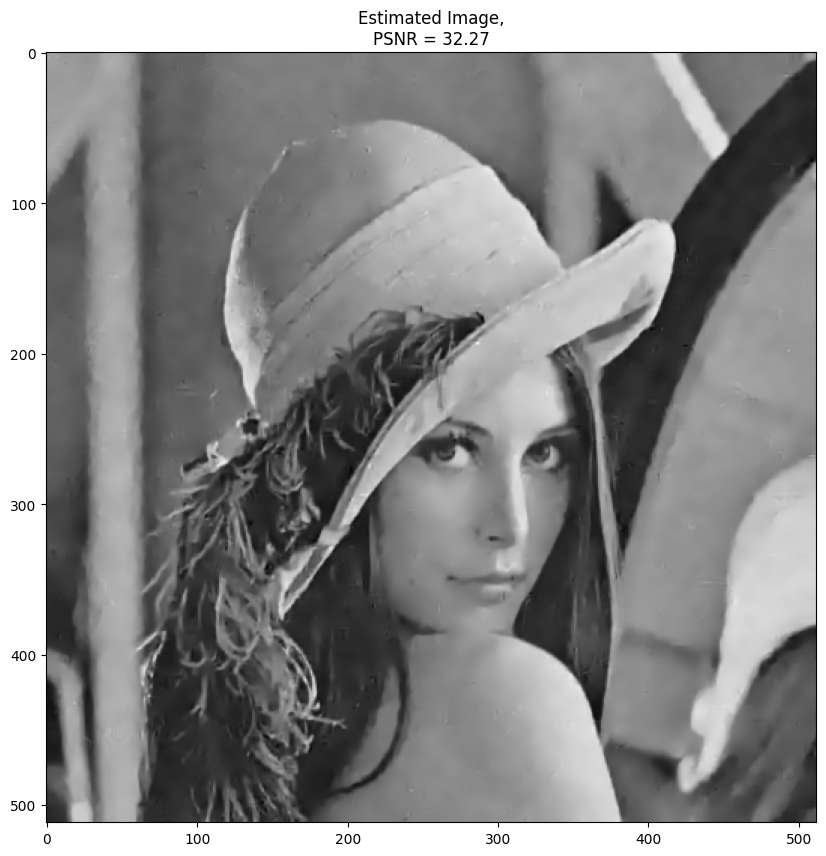

In [14]:
psnr_hat = psnrFun(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
